## Libraries and Installs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import ast
import csv
import cv2
import re
from PIL import Image, ImageDraw
from IPython.display import HTML
from tqdm import tqdm

from datetime import datetime

## Paths

In [2]:
# base folder path
base_path = ''

# if we are on google colab, we mount the drive
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  base_path = './drive/Shareddrives/2020-Makerspace-tracking'

# if we are running it locally, we use the standard gdrive path
# (you will have to update this path)
else: base_path = '/Users/MikeH/Library/CloudStorage/GoogleDrive-michaelhu@college.harvard.edu/Shared drives/2020-Makerspace-tracking/'

In [3]:
# folders we'll be working with
agg_path = os.path.join(base_path, 'Data', '2022-Spr-T519', 'aggregated')
data_path = os.path.join(base_path, 'Data', '2022-Spr-T519', 'poseconnect')
analysis_path = os.path.join(base_path, 'Analysis', '2022-Spr-Week7')

## Helpers ##

In [4]:
joint_names = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

def get_joint(row, joint) -> tuple():
    if joint not in joint_names:
        raise ValueError("Invalid joint name.")
    joint_ind = joint_names[joint]
    return (row[f'{joint_ind}_x'], row[f'{joint_ind}_y'], row[f'{joint_ind}_z'])

def csv_path(file_name):
    return 'csv_files/' + file_name

def closeness_path(file_name):
    return 'closeness/' + file_name

def interval_path(file_name):
    return 'interval/' + file_name

In [6]:
aois = {'laser': [(7.5, 8.5),(7.5, 3.5),(6, 3.5),(6, 8.5)], 
        'soldering': [(7.5, 11.5),(7.5, 8.5),(6, 8.5),(6, 11.5)], 
        'sewing': [(6.5, 2),(6.5, 0.2),(5.5, 0.2),(5.5, 2)],
        'printer': [(3, 1.8),(3, 0.2),(0.05, 0.2),(0.05, 1.8)], 
        'collaboration': [(5.5, 10.5),(5.5, 2),(1.7, 2),(1.7, 10.5)],
        'tool': [(1.4, 8),(1.4, 4.3),(0.2, 4.3),(0.2, 8)], 
        'office': [(1.4, 11.5),(1.4, 8),(0.2, 8),(0.2, 11.5)]}

def in_workspace(center, threshold):
    for aoi_name, aoi_coords in aois.items():
        x_coords, y_coords = zip(*aoi_coords)
        min_x, max_x = min(x_coords), max(x_coords)
        min_y, max_y = min(y_coords), max(y_coords)
        if center[0] >= min_x - threshold and center[0] <= max_x + threshold \
                and center[1] >= min_y - threshold and center[1] <= max_y + threshold:
            return aoi_name
    return None

In [38]:
def remove_millisecond(time):
    if type(time) == str:
        time = datetime.fromisoformat(time)
    return time.replace(microsecond=0)

def same_second(time1, time2):
    return remove_millisecond(time1) == remove_millisecond(time2)

def search_date(filename):
# Use regular expression to extract the date part of the filename
    date_match = re.search(r'\d{4}-\d{2}-\d{2}', filename)
    if date_match:
        date_str = date_match.group()
        return date_str
    else:
        return filename
    
def seconds_between(time1, time2):
    if type(time1) == str:
        time1 = datetime.fromisoformat(time1)
    if type(time2) == str:
        time2 = datetime.fromisoformat(time2)
    return abs((time2 - time1).total_seconds())

In [23]:
teachers = set(['bertrand', 'marc', 'iulian', 'daniel', 'alaa'])
students = set(['xiaoyi', 'hoa', 'yani', 'rhea', 'melissa', 'conner',
                'sara', 'denise', 'rui', 'ji su', 'natalie', 'chali',
                'juan', 'rebecca', 'rachel', 'miaoya', 'aashna'])
people_list = list(students) + list(teachers)

### Velocity

In [11]:
def make_velocity(data, file_name):
    '''Make closeness matrix between each pair of participants
    and the velocity of each participant at each timeframe, and then write them to a csv'''
    
    i = 0
    row = data.iloc[[i]]
    last_positions = [(None, None) for _ in range(len(people_list))]

    # Get the date of the file
    date = search_date(file_name)
    csv_file_name = closeness_path(f'{date}_closeness.csv')
    with open(csv_file_name, mode='w') as csv_file:
        # Create a csv writer object
        writer = csv.writer(csv_file)
        
        # Add people_list as the first row
        writer.writerow(people_list)
        
        # Write the header row
        writer.writerow(['timestamp', 'positions', 'velocities'])
        length = data.shape[0]
        while i < length:
            # The timestamp of the current frame
            frame_millisec = remove_millisecond(row['timestamp'].values[0])  
            positions, velocities = [[] for _ in range(len(people_list))], [None] * len(people_list)
            
            # Let's get the data by seconds
            while same_second(frame_millisec, row['timestamp'].values[0]):
                row = data.iloc[[i]]
                person = data.iloc[[i]]['student_id'].values[0]
                pos = people_list.index(person)
                
                right_hip, left_hip = get_joint(row, 'right_hip'), get_joint(row, 'left_hip')
                right_hip, left_hip = (right_hip[0].values[0], right_hip[1].values[0]), (left_hip[0].values[0], left_hip[1].values[0])
                center = ((right_hip[0] + left_hip[0]) / 2, (right_hip[1] + left_hip[1]) / 2)
                
                positions[pos].append(center)
                
                # we go to the next row
                i += 1
                if i >= length:
                    break
                row = data.iloc[[i]]
                
            # Now we have the positions of each person at each second
            # First, let's take the average of the positions
            for index, position_list in enumerate(positions):
                if len(position_list) == 0:
                    positions[index] = None
                    continue
                position_list = np.array(position_list)
                position_list = np.mean(position_list, axis=0)
                positions[index] = tuple(position_list)
            
            # Now let's calculate the change in direction over the change in time
            for index, position in enumerate(positions):
                if position is None:
                    continue
                last_position, time = last_positions[index]
                if time is not None:
                    time_diff = (frame_millisec - time).total_seconds()
                    if time_diff == 0:
                        continue
                    velocity = (position[0] - last_position[0]) / time_diff, (position[1] - last_position[1]) / time_diff
                    velocities[index] = velocity
                    
                last_positions[index] = (position, frame_millisec)
                
            writer.writerow([frame_millisec, positions, velocities])
    print(f'Finished writing {csv_file_name}!')
 
            
def make_closeness():
    ''' Make the closeness matrix for each file and places it in the closeness folder'''
    
    folder = os.path.join(data_path, 'poseconnect_cleaned')
    for dir in os.listdir(folder):
        if '2022' in dir:
            subfolder = os.path.join(folder, dir)
            for subfile in os.listdir(subfolder):
                # we only care about the 3d reconstructed data
                if subfile.endswith('.csv') and '3d' in subfile and "summary" not in subfile:
                    print(subfile)
                    path = os.path.join(subfolder, subfile)
                        
                    # we read the data and make the 
                    make_velocity(pd.read_csv(path), subfile)

       
def unpack_closeness_csv(filename):
    '''Unpack the closeness csv'''
    
    with open(filename, 'rb') as f:
        # The first line is the list of people indices
        people_list = f.readline().decode('utf-8').strip().split(',')
        
        # The second line is the header to the rest of the csv
        data = pd.read_csv(f)
    return people_list, data

In [10]:
def create_new_image(lab, w, h):
    ''' create a new image with the floorplan '''
    img = Image.new('RGBA', (w,h), (255, 255, 255))
    img.paste(lab, (0, 0), mask=lab)
    return img, ImageDraw.Draw(img, 'RGBA')

def transform_coordinate(w, h, x, y): 
    ''' scales and moves the coordinates to be aligned on the floorplan '''
    new_y = ((x * 90) - w) * -1 - 450
    new_x = ((y * 90) - h) * -1 + 380
    return int(new_x),int(new_y)

def visualize_velocities(file_path, file_name, frames=200, fps=30):
    # Read in the data from the CSV file
    people_list, data = unpack_closeness_csv(file_path)
    
    # Get the positions and velocities for each time frame
    positions = data['positions'].apply(lambda x: eval(x))
    velocities = data['velocities'].apply(lambda x: eval(x))
    
    # Define filepath and remove old files
    video_path = os.path.join(file_name)
    if os.path.isfile(video_path): os.remove(video_path)
    
    # Define the video
    w, h = (1154,732)
    fourcc = cv2.VideoWriter_fourcc('H','2','6','4')
    video = cv2.VideoWriter(video_path, fourcc, fps, (w,h)) 
        
    # Load the background image / font and create a new image
    lab = Image.open('floorplan.png')
    img, draw = create_new_image(lab, w, h)
    
    # Loop through each time frame and draw arrows for the velocities
    for i in tqdm(range(len(positions[:frames]))):
        # Plot the positions as circles
        for j, pos in enumerate(positions[i]):
            if pos is not None:
                x, y = transform_coordinate(w, h, pos[0], pos[1])
                draw.ellipse((x - 10, y - 10, x + 10, y + 10), fill=(0,0,0,255))
                draw.text((x + 10, y + 10), people_list[j], fill=(0,0,0,255))
        
        # Add arrows for the velocities
        for j, vel in enumerate(velocities[i]):
            if vel is not None:
                pos = positions[i][j]
                if pos is not None:
                    x, y = transform_coordinate(w, h, pos[0], pos[1])
                    u, v = pos[0] + vel[0], pos[1] + vel[1]
                    u, v = transform_coordinate(w, h, u, v)
                    draw.line((x, y, u, v), fill=(100,149,237,255), width=5)
                    
        # Add the time to the image
        draw.text((10, 10), str(data['timestamp'][i]), fill=(0,0,0,255))
        
        # Save the figure as a numpy array and add it to the video
        video.write(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))
        img,draw = create_new_image(lab,w,h)
    
    # Release the video writer
    video.release()
    
    print(f"Video saved to {video_path}")

In [12]:
visualize_velocities(closeness_path('2022-03-03_closeness.csv'), 'velocity.mp4', frames=200, fps=20)

HTML("""
<video width="640" controls>
  <source src="velocity.mp4" type="video/mp4">
</video>
""")

OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
100%|██████████| 200/200 [00:05<00:00, 35.22it/s]


Video saved to velocity.mp4


In [30]:
make_closeness()

3d_2022-03-06.csv
Finished writing closeness/2022-03-06_closeness.csv!
3d_2022-03-08.csv
Finished writing closeness/2022-03-08_closeness.csv!
3d_2022-03-09.csv
Finished writing closeness/2022-03-09_closeness.csv!
3d_2022-03-07.csv
Finished writing closeness/2022-03-07_closeness.csv!
3d_2022-03-05.csv
Finished writing closeness/2022-03-05_closeness.csv!
3d_2022-03-04.csv
Finished writing closeness/2022-03-04_closeness.csv!
3d_2022-03-03.csv
Finished writing closeness/2022-03-03_closeness.csv!


### Intervals

In [42]:
def make_intervals(data, people_list, file_name, threshold, filter_short_intervals=True, filter_threshold=3, aoi_padding=0):
    '''Make closeness matrix between each pair of participants
    and the velocity of each participant at each timeframe, and then write them to a csv
    The threshold is the number of seconds that a person had to be out of frame for them
    to be considered out of the workspace'''
    
    # Get the date of the file
    people_dict_general = {person: [] for person in people_list}
    people_dict_workspace = {aoi: {person: [] for person in people_list} for aoi in aois}
    
    timestamp = data.iloc[0]['timestamp']
    # Iterate through the csv file
    for _, row in data.iterrows():
        timestamp = row['timestamp']
        positions = ast.literal_eval(row['positions'])
        
        for i in range(len(positions)):
            person, position = people_list[i], positions[i]
            
            # If the person is in the frame, we check if we've recorded a start interval
            # for them already, and if not, we record it
            if position is not None:
                if len(people_dict_general[person]) == 0 or people_dict_general[person][-1][1] is not None:
                    people_dict_general[person].append((timestamp, None))
                    
                workspace = in_workspace(position, aoi_padding)
          
                for aoi in aois:
                    if aoi == workspace:
                        if len(people_dict_workspace[aoi][person]) == 0 or people_dict_workspace[aoi][person][-1][1] is not None:
                            people_dict_workspace[aoi][person].append((timestamp, None))
                    else:
                        if len(people_dict_workspace[aoi][person]) > 0 and people_dict_workspace[aoi][person][-1][1] is None:
                            people_dict_workspace[aoi][person][-1] = (people_dict_workspace[aoi][person][-1][0], timestamp)
                        
            # If the person is not in the frame, we check if we've recorded an start interval
            # if we have, we record the end interval and the duration of the interval
            else:
                person_general_list = people_dict_general[person]
                if len(person_general_list) > 0 and person_general_list[-1][1] is None:
                    person_general_list[-1] = (person_general_list[-1][0], timestamp)
                    
                for aoi in aois:
                    if len(people_dict_workspace[aoi][person]) > 0 and people_dict_workspace[aoi][person][-1][1] is None:
                        people_dict_workspace[aoi][person][-1] = (people_dict_workspace[aoi][person][-1][0], timestamp)
                        
    # Closing all the intervals that are still open
    for person in people_dict_general:
        lst = people_dict_general[person]
        for i in range(len(lst)):
            if lst[i][1] is None:
                lst[i] = (lst[i][0], timestamp)
                
    for aoi in people_dict_workspace:
        for person in people_dict_workspace[aoi]:
            lst = people_dict_workspace[aoi][person]
            for i in range(len(lst)):
                if lst[i][1] is None:
                    lst[i] = (lst[i][0], timestamp)
                    
    # Using the threshold to filter out intervals that are too short
    # Also, if the gap between two intervals is shorter than the threshold, we just combine them
    for person in people_dict_general:
        lst = people_dict_general[person]
        
        # combine adjacent intervals
        combined_lst = []
        if len(lst) > 0:
            current_interval = lst[0]
            for interval in lst[1:]:
                # if the gap between the two intervals is less than the threshold, we combine them
                if seconds_between(interval[0], current_interval[1]) < threshold:
                    current_interval = (current_interval[0], interval[1])
                else:
                    combined_lst.append(current_interval)
                    current_interval = interval
            combined_lst.append(current_interval)
        
        if filter_short_intervals:
            # filter out short intervals
            filtered_lst = []
            for interval in combined_lst:
                duration = seconds_between(interval[0], interval[1])
                if duration >= filter_threshold:
                    filtered_lst.append(interval)
            
            people_dict_general[person] = filtered_lst
        else:
            people_dict_general[person] = combined_lst
            
    # Do the same for each workspace data
    for aoi in people_dict_workspace:
        for person in people_dict_workspace[aoi]:
            lst = people_dict_workspace[aoi][person]
            
            # combine adjacent intervals
            combined_lst = []
            if len(lst) > 0:
                current_interval = lst[0]
                for interval in lst[1:]:
                    # if the gap between the two intervals is less than the threshold, we combine them
                    if seconds_between(interval[0], current_interval[1]) < threshold:
                        current_interval = (current_interval[0], interval[1])
                    else:
                        combined_lst.append(current_interval)
                        current_interval = interval
                combined_lst.append(current_interval)
            
            if filter_short_intervals:
                # filter out short intervals
                filtered_lst = []
                for interval in combined_lst:
                    duration = seconds_between(interval[0], interval[1])
                    if duration >= filter_threshold:
                        filtered_lst.append(interval)
                
                people_dict_workspace[aoi][person] = filtered_lst
            else:
                people_dict_workspace[aoi][person] = combined_lst
    
    # Convert the lists of intervals to strings, and then to a dataframe
    people_dict_general = {person: str(people_dict_general[person]) for person in people_dict_general}
    people_dict_workspace = {aoi: {person: str(people_dict_workspace[aoi][person]) for person in people_dict_workspace[aoi]} for aoi in people_dict_workspace}
    df = pd.DataFrame.from_dict(people_dict_general, orient='index', columns=['general'])
    for wp in people_dict_workspace:
        df = df.join(pd.DataFrame.from_dict(people_dict_workspace[wp], orient='index', columns=[wp]))
        
    # Save the dataframe to a csv file
    df.to_csv(file_name, index=True, index_label='student_id')


def process_interval_files(threshold=5, filter_short_intervals=True, filter_threshold=30, aoi_padding=0): 
    ''' Processes all the interval files in the interval folder '''
    
    for file in os.listdir(closeness_path('')):
        # we only care about the 3d reconstructed data
        if file.endswith('.csv'):
            print(file)
            path = closeness_path(file)
            people_list, data = unpack_closeness_csv(path)
            date = search_date(file)
            interval_file_name = interval_path(f'{date}_intervals.csv')
            make_intervals(data, people_list, interval_file_name, threshold, filter_short_intervals, filter_threshold, aoi_padding)
            

def unpack_interval_csv(file):
    ''' Unpacks the interval csv file into a dictionary of people and a list of their intervals '''
    
     # Load the csv file into a pandas DataFrame
    df = pd.read_csv(file)

    # Convert timestamp strings to datetime objects
    for col in df.columns[1:]:
        df[col] = df[col].apply(lambda x: eval(x))
        df[col] = df[col].apply(lambda x: [(datetime.fromisoformat(start), datetime.fromisoformat(end)) for start, end in x])
        
    return df


def visualize_intervals(file, bar_height=0.5):
    ''' Visualizes the intervals in the given file in a matplotlib plot '''
    
    df = unpack_interval_csv(file)

    # Create a list of tuples representing the time intervals for each student and workspace
    intervals = []
    for _, row in df.iterrows():
        for col in df.columns[1:]:
            for start, end in row[col]:
                intervals.append((row['student_id'], col, start, end))

    # Create a new DataFrame with one row for each interval
    df_intervals = pd.DataFrame(intervals, columns=['student_id', 'workspace', 'start', 'end'])

    # Group the intervals by student and workspace
    grouped = df_intervals.groupby(['student_id', 'workspace'])

    # Create a new figure
    fig, ax = plt.subplots(figsize=(len(df.columns[1:]) * 2, len(df) * bar_height))

    # Define a color map for workspaces
    cmap = plt.get_cmap('tab20')
    colors = {workspace: cmap(i) for i, workspace in enumerate(df.columns[1:])}

    # Plot each interval as a horizontal bar
    for i, ((student, workspace), group) in enumerate(grouped):
        y = i * bar_height
        for _, row in group.iterrows():
            x_start = row['start']
            x_end = row['end']
            color = colors[row['workspace']]
            ax.plot([x_start, x_end], [y, y], linewidth=3, color=color)

    # Set the x-axis label and format
    ax.set_xlabel('Time')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    # Set the y-axis ticks and labels
    ax.set_yticks([i * bar_height for i in range(len(grouped))])
    ax.set_yticklabels([f"{student}-{workspace}" for (student, workspace), _ in grouped])

    # Set the title and show the plot
    ax.set_title('Intervals')

    plt.show()

2022-03-08_closeness.csv
2022-03-06_closeness.csv
2022-03-05_closeness.csv
2022-03-04_closeness.csv
2022-03-07_closeness.csv
2022-03-03_closeness.csv
2022-03-09_closeness.csv
2022-03-05_intervals.csv


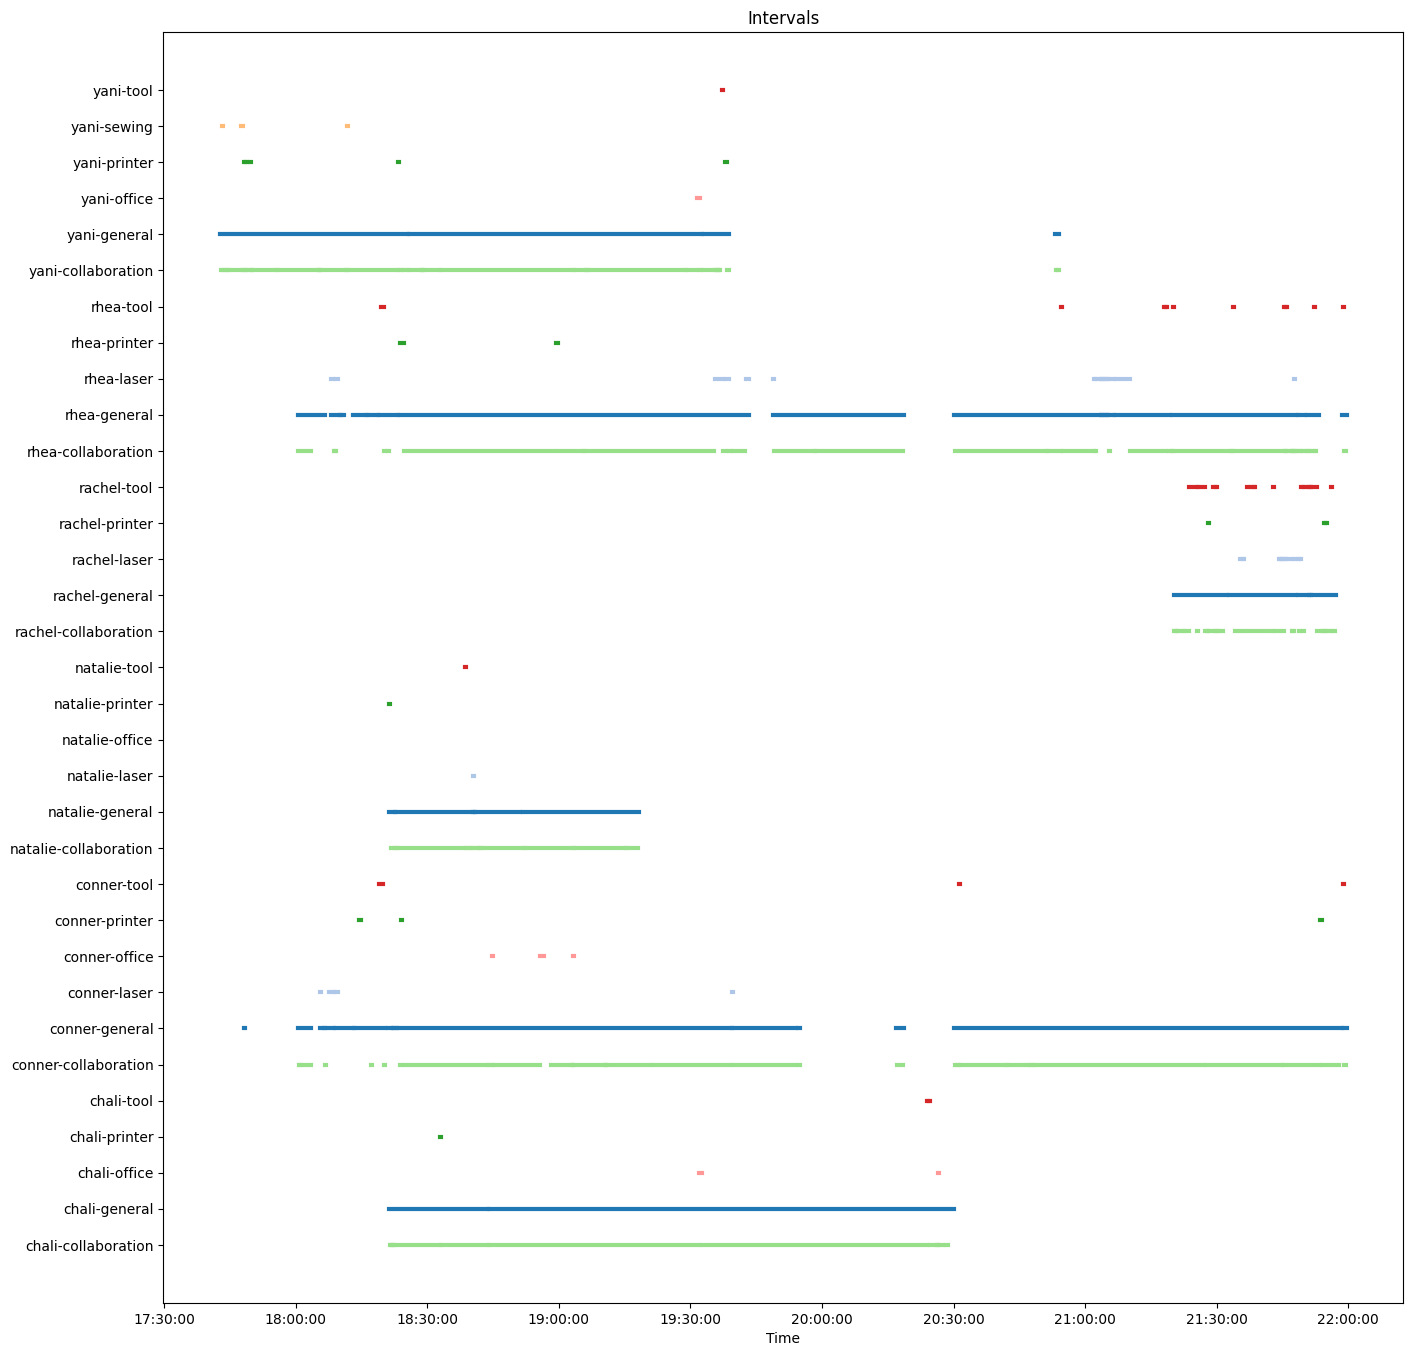

2022-03-06_intervals.csv


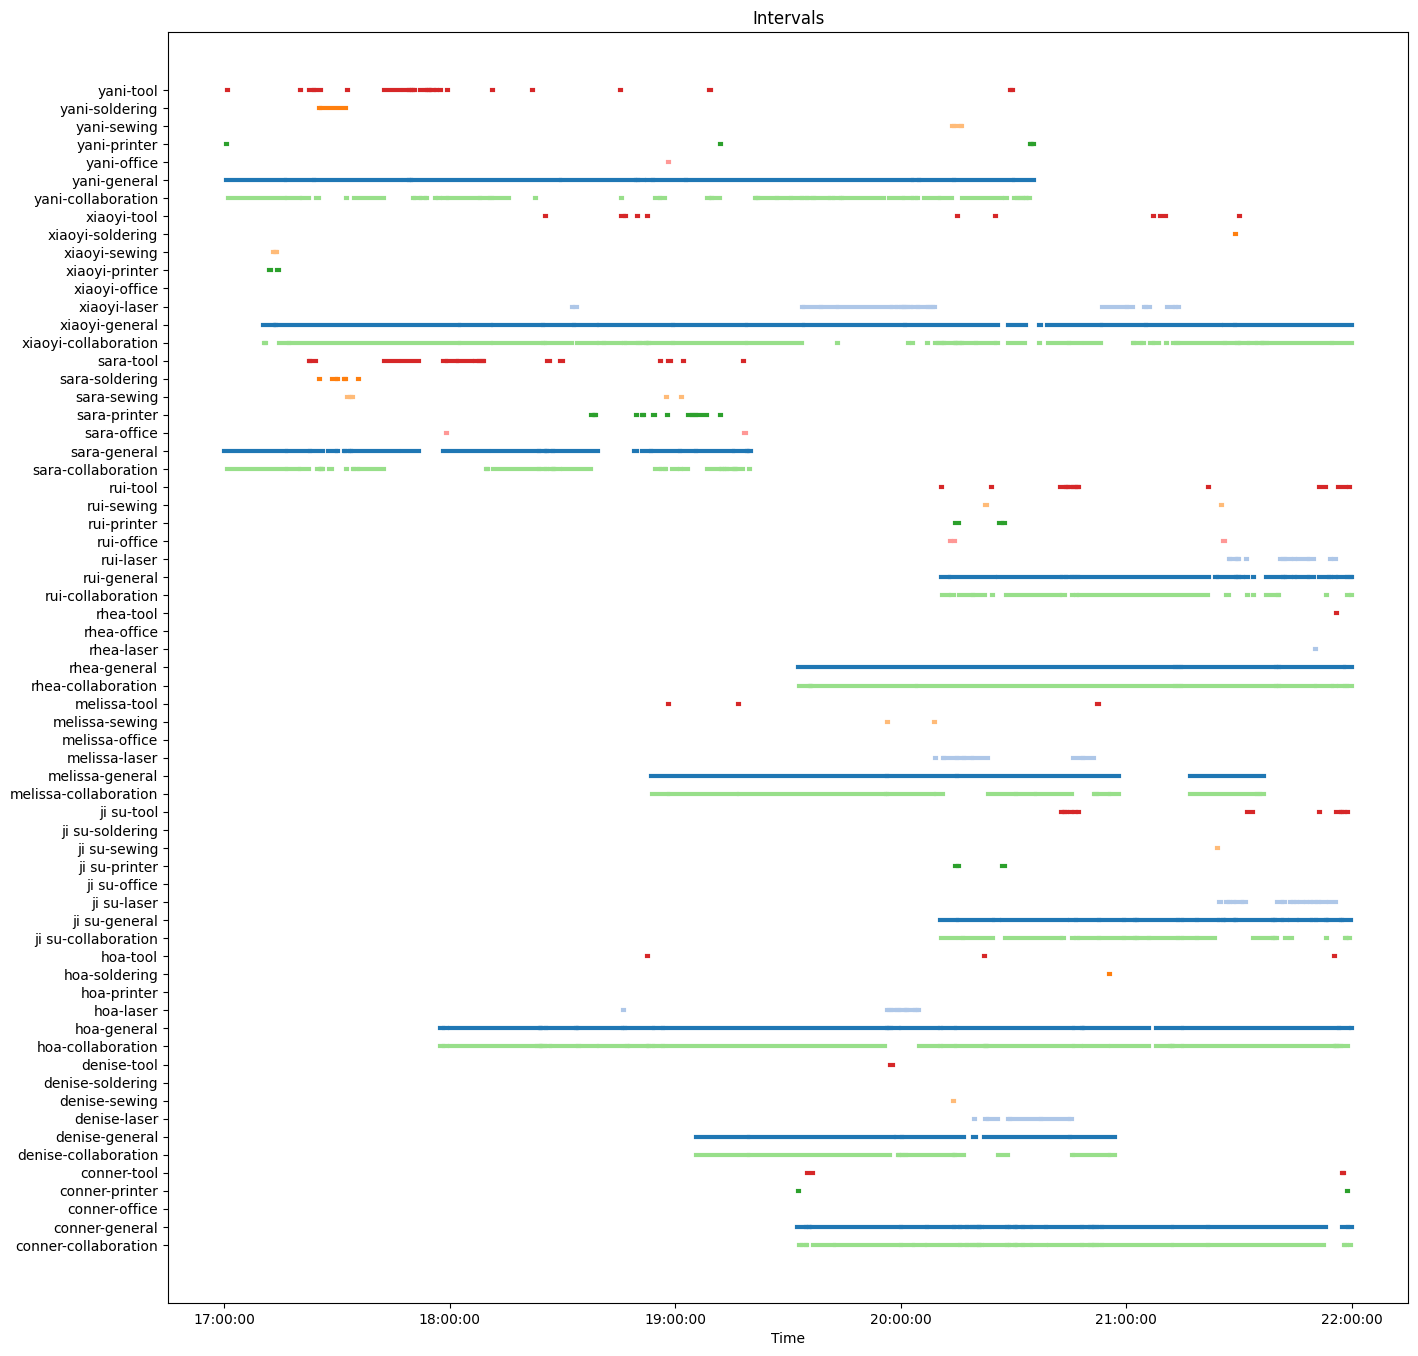

2022-03-08_intervals.csv


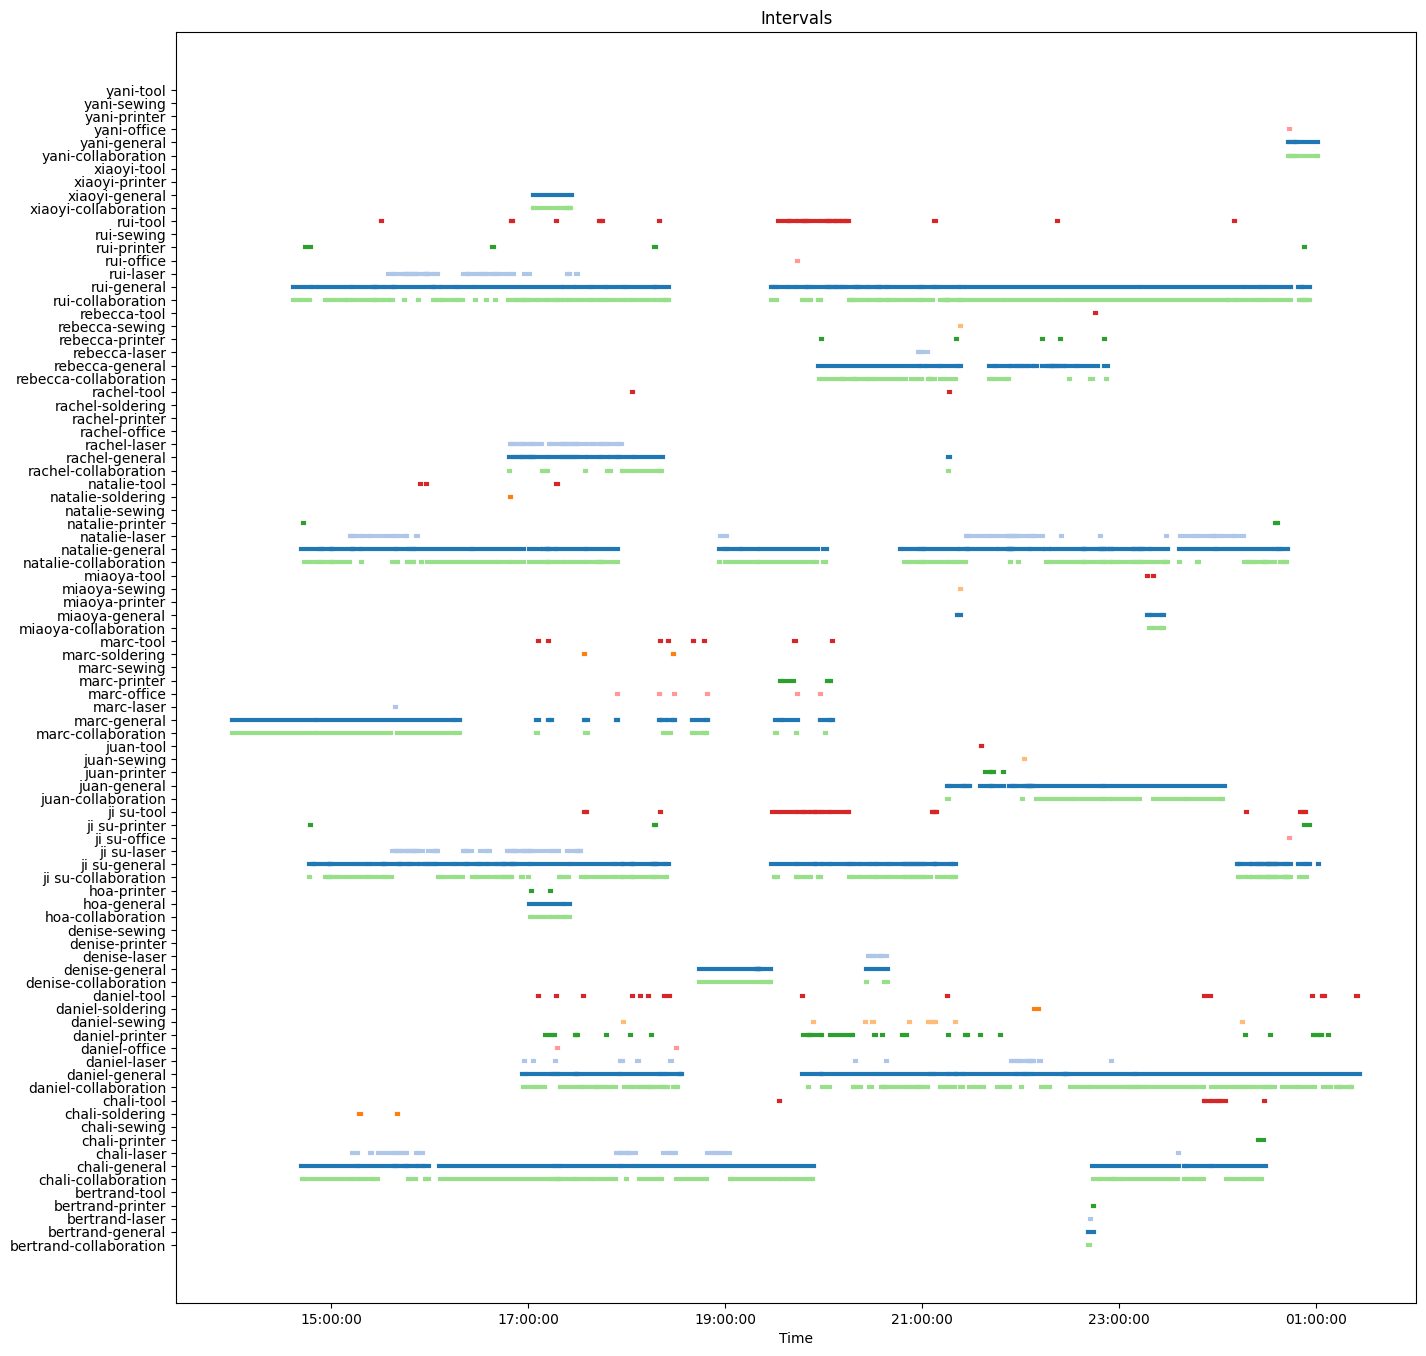

2022-03-09_intervals.csv


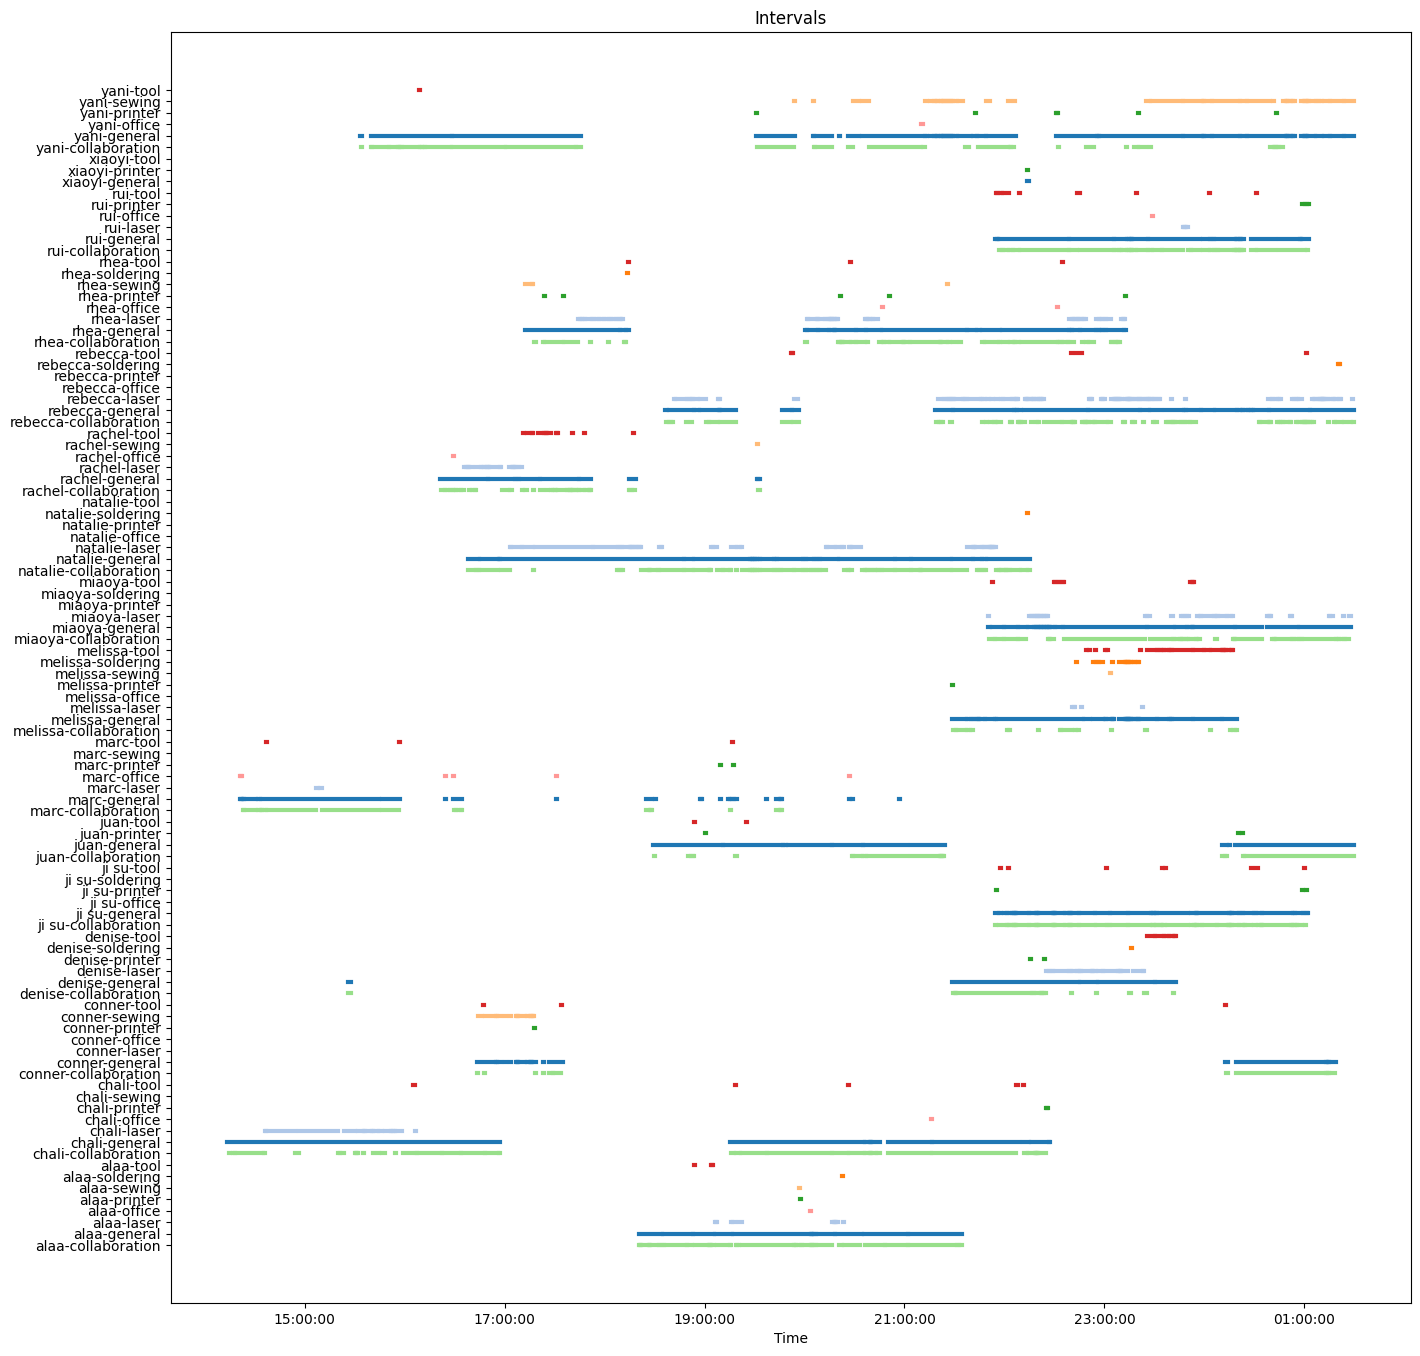

2022-03-07_intervals.csv


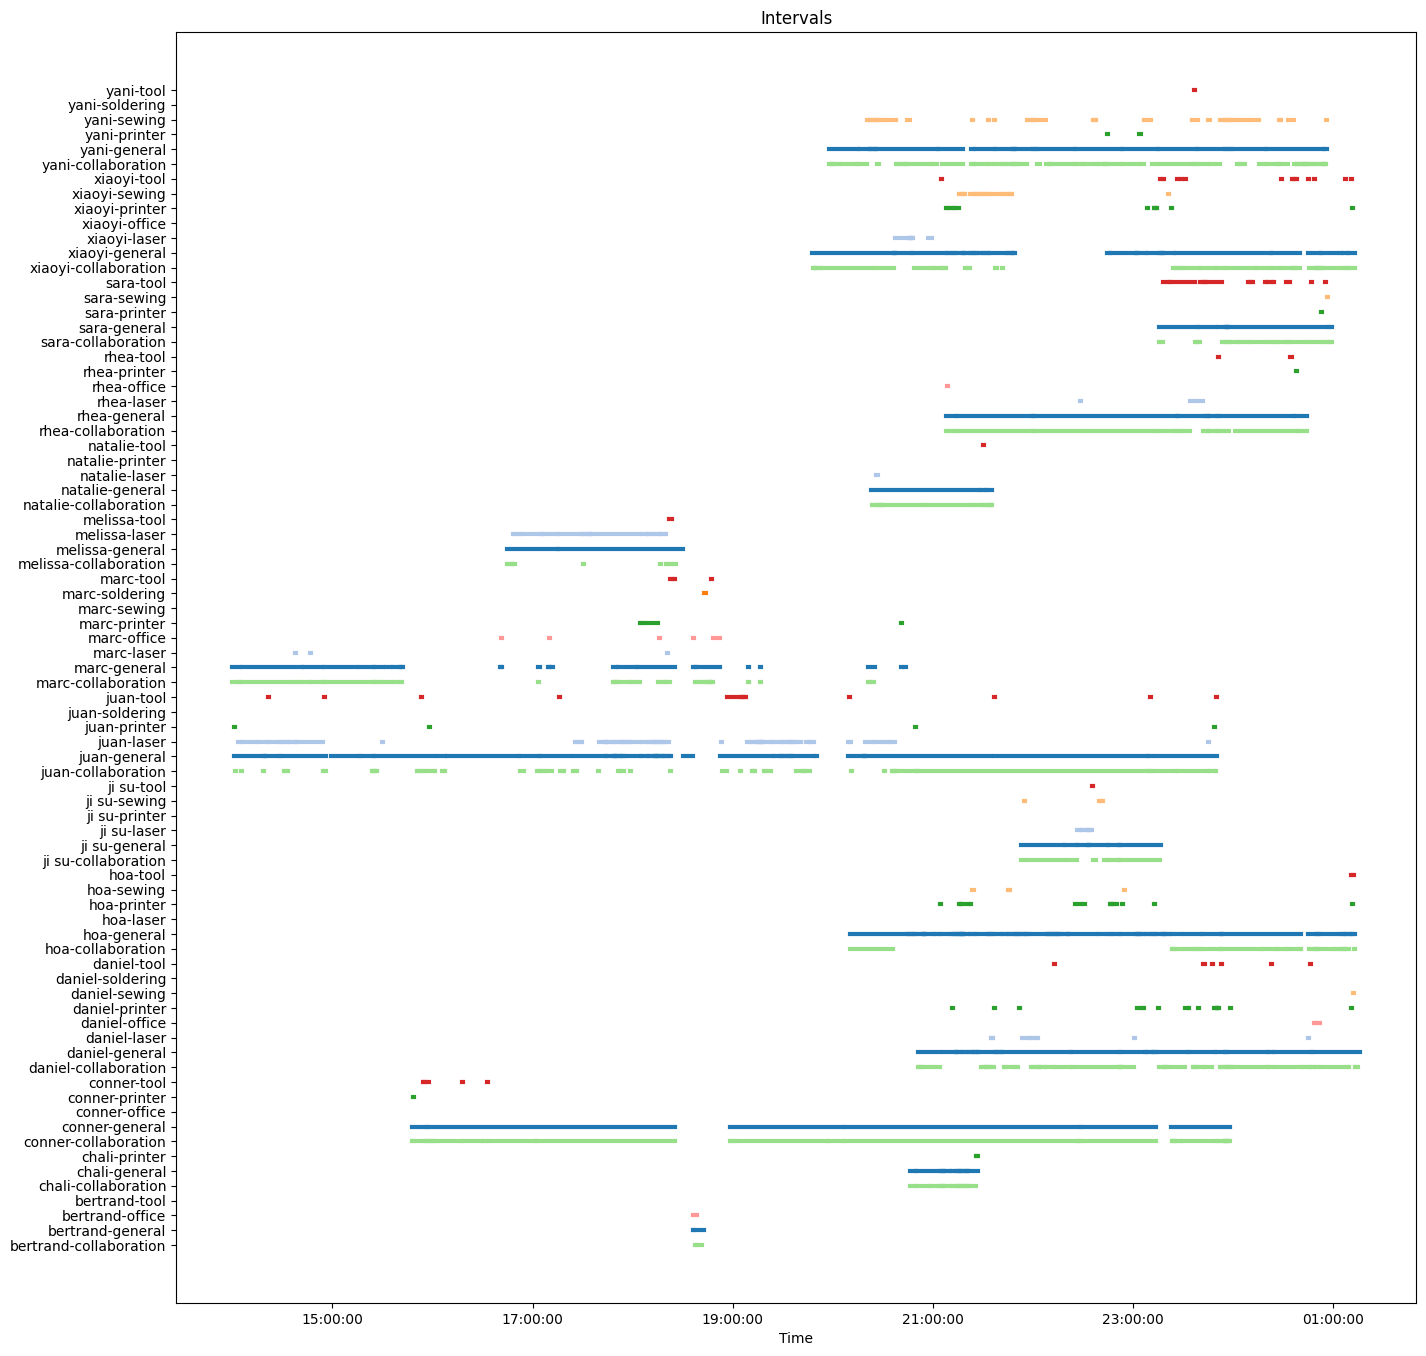

2022-03-03_intervals.csv


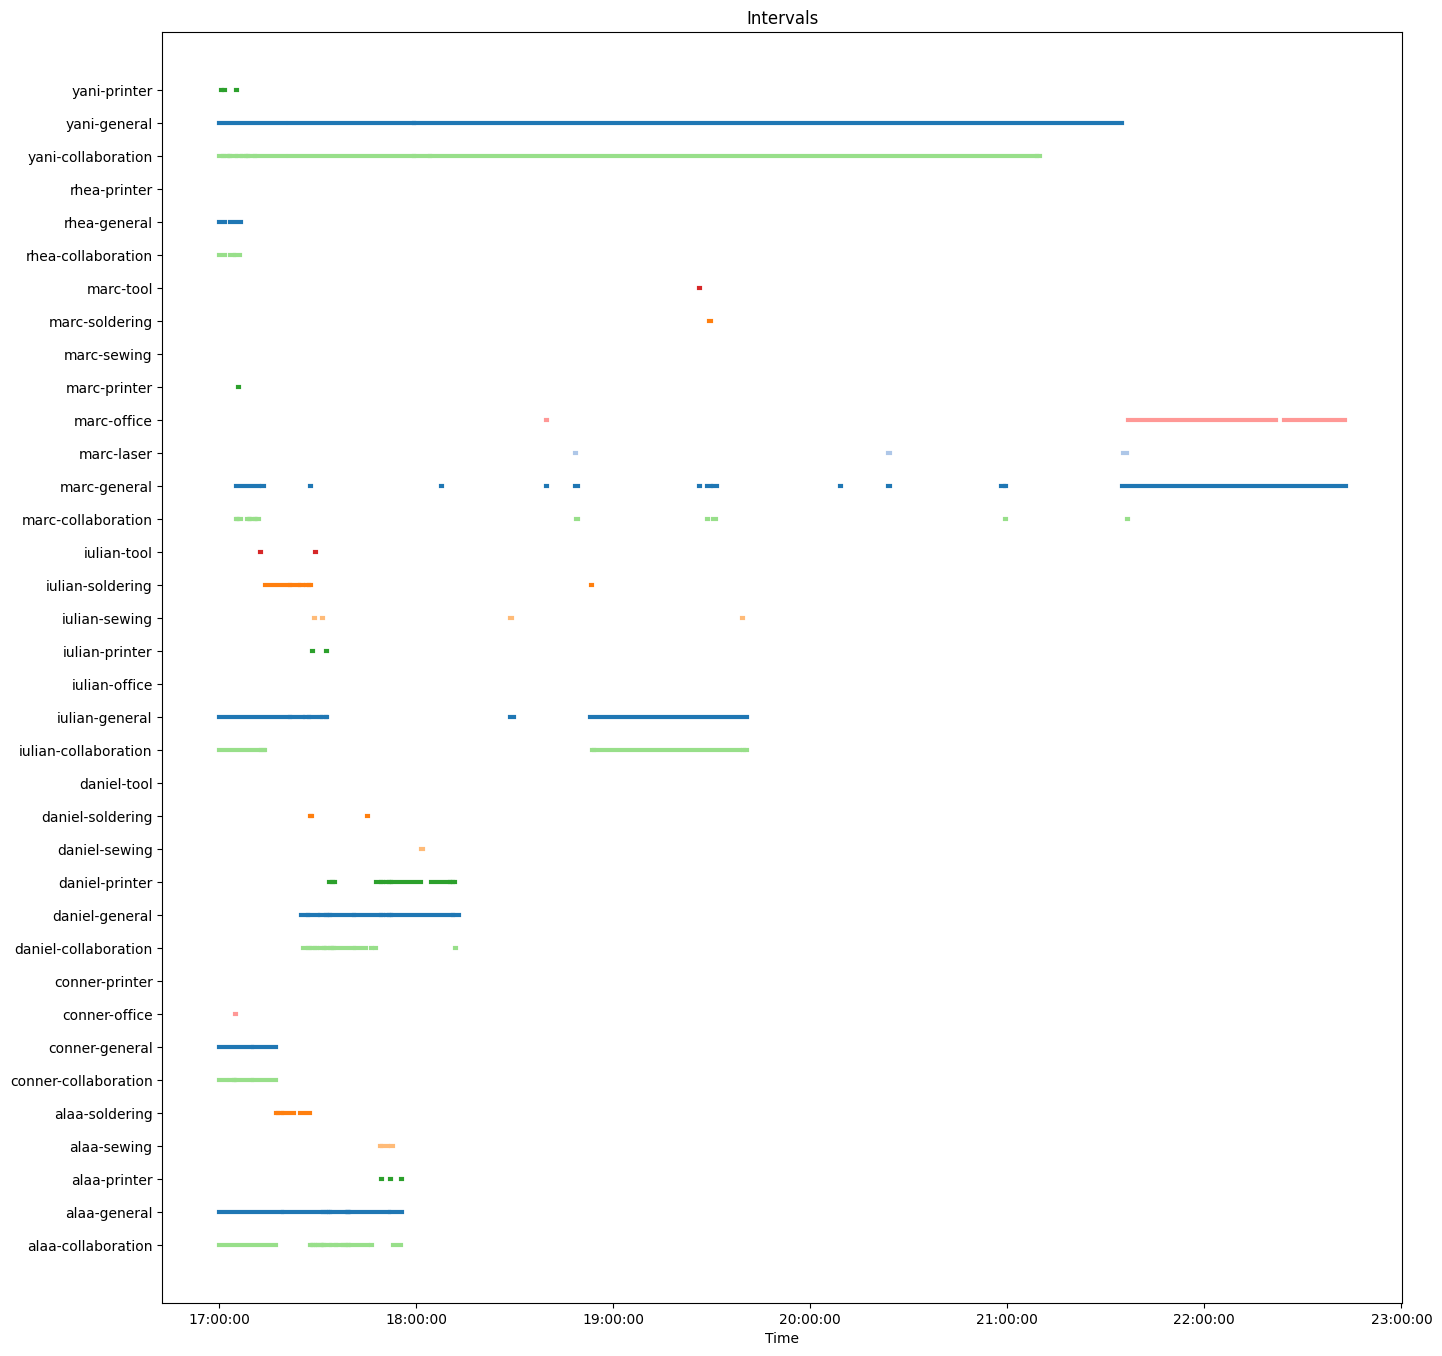

2022-03-04_intervals.csv


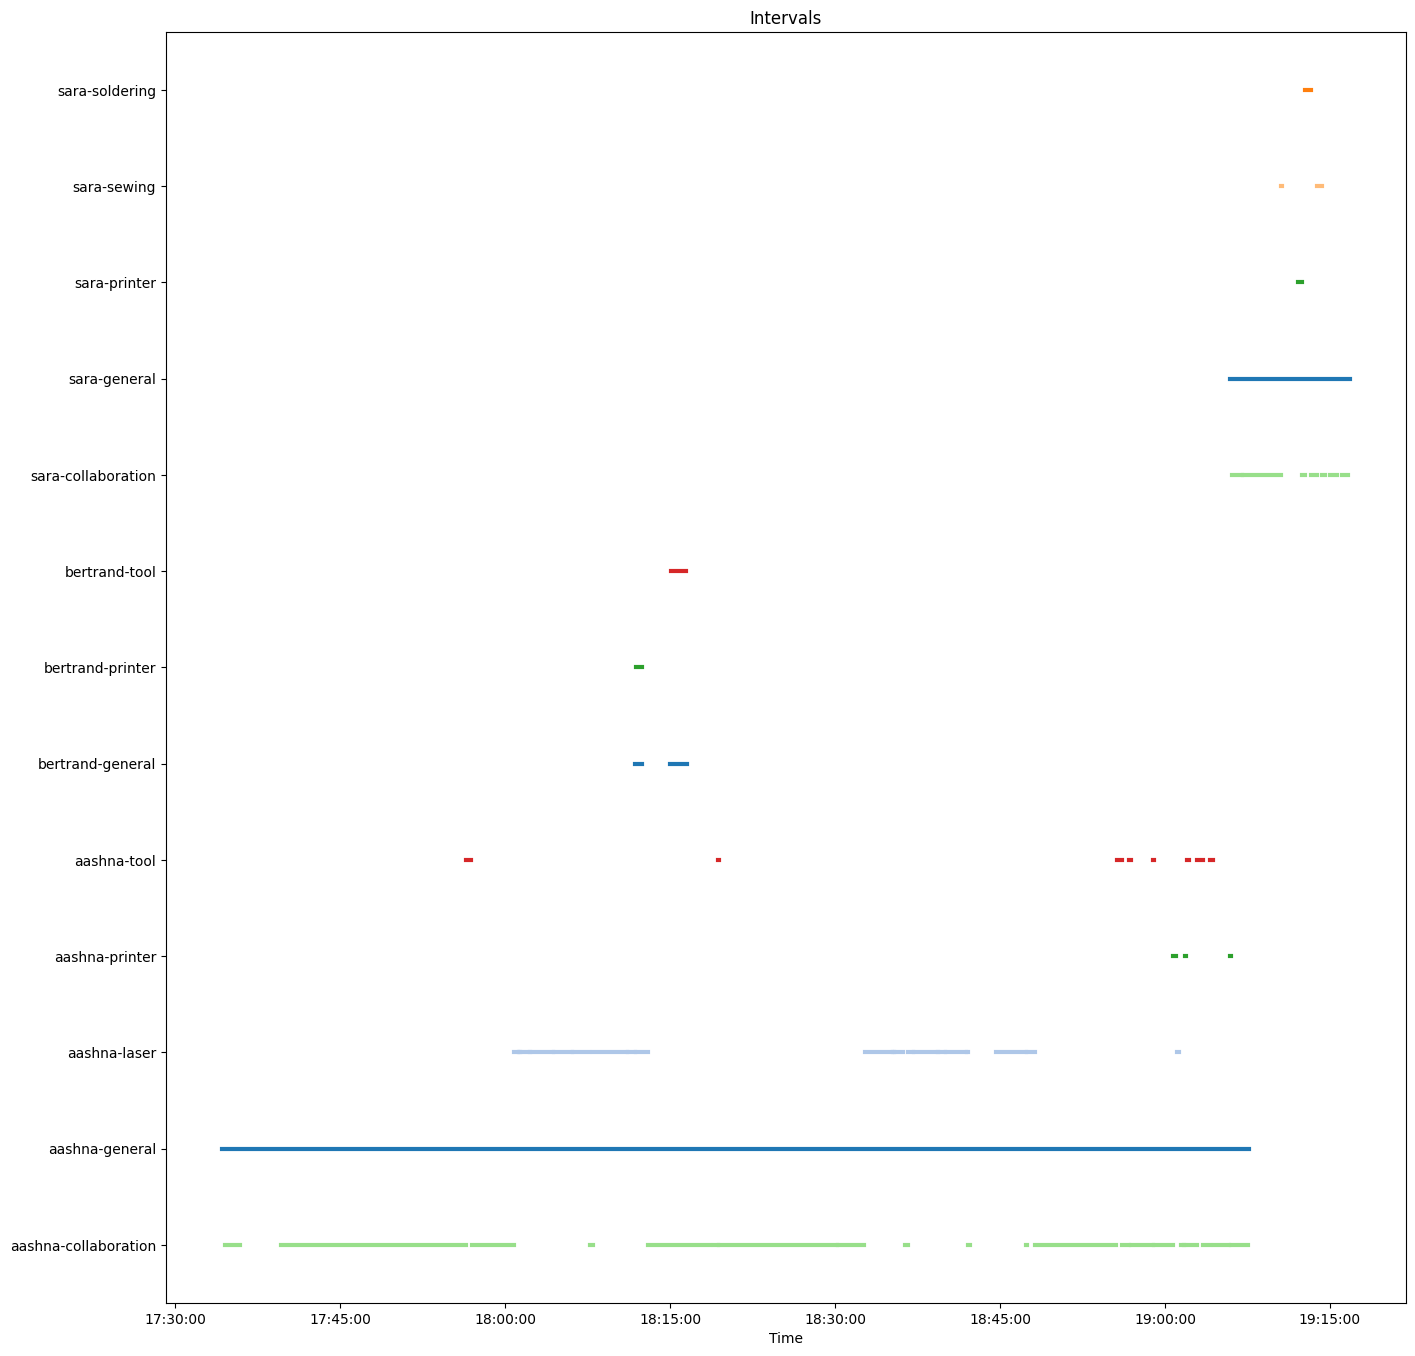

In [48]:
process_interval_files(3, filter_short_intervals=True, filter_threshold=3, aoi_padding=0.1)
# unpack_interval_csv(interval_path('2022-03-09_intervals.csv'))
for file in os.listdir(interval_path('')):
    print(file)
    visualize_intervals(interval_path(file), bar_height=0.75)